In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

from utility import (
    getPossibleActions,
    performAction,
    ageEntanglements,
    generateEntanglement,
    jains_index,
    min_max_fairness,
    rolling_average
)


    
def print_greedy_summary(results_dict, goal_edges):
    """
    Print summary statistics for greedy policy simulation results.
    Accepts the dictionary structure outputted by simulate_policy_multi_greedy().
    """
    for policy, res in results_dict.items():
        print(f"\n--- Summary for policy: {policy.upper()} ---")
        total_time = res['total_timesteps']
        goals_achieved = res['goals_achieved']
        final_edrs = {g: goals_achieved[g] / max(1, total_time) for g in goal_edges}
        
        # Print per-goal EDR
        for g in goal_edges:
            print(f"  Goal {g} EDR: {final_edrs[g]:.4f}")
        
        # Print totals
        throughput = sum(final_edrs.values())
        fairness = jains_index(final_edrs)
        print(f"  Total Throughput: {throughput:.4f}")
        print(f"  Jain's Fairness Index: {fairness:.4f}")
        print(f"  Aged-Out Ratio (last 1000 steps): {np.mean(res['aged'][-1000:]):.4f}")
        print(f"  Action Decision Ratio (last 1000 steps): {np.mean(res['actions'][-1000:]):.4f}")


def dict_to_state(state_dict):
    return [(edge, age) for edge, age in sorted(state_dict.items())]

def state_to_dict(state_list):
    return {edge: age for edge, age in state_list}

import random

def choose_action(policy_type, actions, goal_success_counts, total_timesteps, pSwap):
    if not actions:
        return ([], None)

    if policy_type == 'random':
        return random.choice(actions)

    if policy_type == 'spf':
        min_length = min(len(path) for path, _ in actions)
        shortest_actions = [action for action in actions if len(action[0]) == min_length]
        return random.choice(shortest_actions)

    if policy_type == 'lowest_edr':
        return min(actions, key=lambda x: goal_success_counts.get(x[1], 0) / max(1, total_timesteps))

    if policy_type == 'utility':
        def utility(action):
            path, goal = action
            if not goal or not path:
                return 0
            rate = pSwap ** (len(path) - 1)
            edr = goal_success_counts.get(goal, 0) / max(1, total_timesteps)
            return np.log(1+rate / max(1e-4, edr))
        return max(actions, key=utility)

    return ([], None)


def simulate_policy_multi_greedy(edges, goalEdges, pSwap, pGen, maxAge, policy_type, num_steps=10000):
    total_timesteps = 0
    goal_success_counts = {goal: 0 for goal in goalEdges}
    goal_attempt_counts = {goal: 0 for goal in goalEdges}
    edr_history = {goal: [] for goal in goalEdges}
    fairness_history = {'jains_index': [], 'min_max_ratio': [], 'cv': []}
    aged_out_history = []
    action_ratio_history = []

    current_state = {edge: -1 for edge in edges}

    for step in range(num_steps):
        state_list = dict_to_state(current_state)
        possible_actions = getPossibleActions(state_list, goalEdges)
        valid_actions = [a for a in possible_actions if a[0]]

        best_action = choose_action(policy_type, valid_actions, goal_success_counts, total_timesteps, pSwap)

        action_taken = best_action and best_action != ([], None)
        action_ratio_history.append(1.0 if valid_actions and action_taken else 0.0)

        if action_taken:
            consumed_edges, goal = best_action
            goal_attempt_counts[goal] += 1
            if random.random() < pSwap ** (len(consumed_edges) - 1):
                goal_success_counts[goal] += 1

        num_existing_before = sum(1 for _, age in state_list if age >= 0)
        state_list = performAction(best_action, state_list)
        state_list = ageEntanglements(state_list, maxAge)
        num_existing_after = sum(1 for _, age in state_list if age >= 0)
        num_aged_out = num_existing_before - num_existing_after

        state_list = generateEntanglement(state_list, pGen)
        current_state = state_to_dict(state_list)
        num_generated = sum(1 for _, age in state_list if age == 1)

        aged_out_ratio = num_aged_out / (num_aged_out + num_generated) if num_generated > 0 else 0.0
        aged_out_history.append(aged_out_ratio)

        total_timesteps += 1
        current_edrs = {goal: goal_success_counts[goal] / total_timesteps for goal in goalEdges}
        for goal in goalEdges:
            edr_history[goal].append(current_edrs[goal])

        jains = jains_index(current_edrs)
        minmax = min_max_fairness(current_edrs)
        cv = np.std(list(current_edrs.values())) / max(1e-6, np.mean(list(current_edrs.values())))
        fairness_history['jains_index'].append(jains)
        fairness_history['min_max_ratio'].append(minmax)
        fairness_history['cv'].append(cv)
    return edr_history, fairness_history, goal_success_counts, goal_attempt_counts, total_timesteps, aged_out_history, action_ratio_history

def plot_greedy_policy_results(results, goalEdges):
    print_greedy_summary(results, goal_edges)
    fig, axs = plt.subplots(2, 3, figsize=(22, 12))
    policy_colors = {'spf': 'blue', 'random': 'green', 'lowest_edr': 'purple', 'utility': 'red'}

    # --- EDR Evolution ---
    for policy, res in results.items():
        for i, goal in enumerate(goalEdges):
            linestyle = '-' if i == 0 else '--'
            axs[0][0].plot(
                res['edr_history'][goal],
                label=f'{policy} - Goal {goal}',
                color=policy_colors.get(policy),
                linestyle=linestyle
            )
    axs[0][0].set_title("EDR Evolution Over Time")
    axs[0][0].set_xlabel("Timestep")
    axs[0][0].set_ylabel("EDR")
    axs[0][0].set_ylim(0, 1.05)
    axs[0][0].legend()
    axs[0][0].grid(True)

    # --- Jain's Fairness ---
    for policy, res in results.items():
        axs[0][1].plot(
            res['fairness_history']['jains_index'],
            label=policy,
            color=policy_colors.get(policy)
        )
    axs[0][1].set_title("Jain's Fairness Index Over Time")
    axs[0][1].set_xlabel("Timestep")
    axs[0][1].set_ylabel("Jain's Index")
    axs[0][1].set_ylim(0, 1.05)
    axs[0][1].legend()
    axs[0][1].grid(True)

    # --- Min-Max Ratio ---
    for policy, res in results.items():
        axs[1][0].plot(
            res['fairness_history']['min_max_ratio'],
            label=policy,
            color=policy_colors.get(policy)
        )
    axs[1][0].set_title("Min-Max Fairness Ratio Over Time")
    axs[1][0].set_xlabel("Timestep")
    axs[1][0].set_ylabel("Min/Max Ratio")
    axs[1][0].set_ylim(0, 1.05)
    axs[1][0].legend()
    axs[1][0].grid(True)

    # --- Pareto Curve ---
    for policy, res in results.items():
        final_edrs = {g: res['goals_achieved'][g] / max(1, res['total_timesteps']) for g in goalEdges}
        throughput = sum(final_edrs.values())
        jain = jains_index(final_edrs)
        axs[1][1].scatter([throughput], [jain], label=policy, color=policy_colors.get(policy), s=80)

    axs[1][1].set_title("Pareto Curve: Throughput vs Jain's Index")
    axs[1][1].set_xlabel("Total Throughput")
    axs[1][1].set_ylabel("Jain's Index")
    axs[1][1].set_xlim(0, len(goalEdges))  # assuming max throughput = number of goals
    axs[1][1].set_ylim(0, 1.05)
    axs[1][1].grid(True)
    axs[1][1].legend()

    # Hide unused subplot (2,2)
    axs[1][2].axis('off')

    plt.tight_layout()
    plt.show()


def run_greedy_param_sweep(edges, goalEdges, param_name, param_values, fixed_params, num_steps=10000, policy='utility', plot=True):
    assert param_name in ['pGen', 'pSwap']
    all_results = {}

    for val in param_values:
        pGen = val if param_name == 'pGen' else fixed_params['pGen']
        pSwap = val if param_name == 'pSwap' else fixed_params['pSwap']
        print(f"Running {policy.upper()} with {param_name}={val}")

        edr_history, fairness_history, goals_achieved, goal_attempts, total_timesteps, aged, actions = simulate_policy_multi_greedy(
            edges, goalEdges, pSwap, pGen, fixed_params['maxAge'], policy, num_steps
        )
        final_edrs = {g: goals_achieved[g] / total_timesteps for g in goalEdges}
        all_results[val] = {
            "edrs": final_edrs,
            "jain": jains_index(final_edrs),
            "minmax": min_max_fairness(final_edrs),
            "throughput": sum(final_edrs.values()),
            "aged": np.mean(aged[-1000:]),
            "actions": np.mean(actions[-1000:])
        }

    if plot:
        plot_greedy_param_sweep(all_results, param_values, param_name, goalEdges)

    return all_results

def plot_greedy_param_sweep(results, param_vals, param_name, goalEdges):
    fig, axs = plt.subplots(2, 3, figsize=(22, 10)); axs = axs.flatten()
    for goal in goalEdges:
        axs[0].plot(param_vals, [results[v]['edrs'][goal] for v in param_vals], marker='o', label=f"Goal {goal}")
    axs[0].set_title("EDR per Goal"); axs[0].legend(); axs[0].grid()

    axs[1].plot(param_vals, [results[v]['jain'] for v in param_vals], color='purple', marker='o')
    axs[1].set_title("Jain's Index"); axs[1].grid()

    axs[2].plot(param_vals, [results[v]['minmax'] for v in param_vals], color='green', marker='o')
    axs[2].set_title("Min-Max Ratio"); axs[2].grid()

    axs[3].scatter([results[v]['throughput'] for v in param_vals],
               [results[v]['jain'] for v in param_vals],
               color='darkred')
    axs[3].set_title("Pareto Curve: Throughput vs Jain's Index")
    axs[3].set_xlabel("Total Throughput (Sum of EDRs)")
    axs[3].set_ylabel("Jain's Fairness Index")
    axs[3].grid(True)


    axs[4].plot(param_vals, [results[v]['aged'] for v in param_vals], color='orange', marker='o')
    axs[4].set_title("Aged-Out Ratio"); axs[4].grid()

    axs[5].plot(param_vals, [results[v]['actions'] for v in param_vals], color='teal', marker='o')
    axs[5].set_title("Action Decision Ratio"); axs[5].grid()

    plt.tight_layout()
    plt.show()
    
def plot_full_greedy_param_analysis(results, param_vals, param_name, goal_edges, policy_name="Greedy"):
    fig, axs = plt.subplots(2, 3, figsize=(36, 12))
    axs = axs.flatten()

    # --- EDR per Goal
    for goal in goal_edges:
        edrs = [results[v]['edrs'][goal] for v in param_vals]
        axs[0].plot(param_vals, edrs, marker='o', label=f"Goal {goal}")
    axs[0].set_title("Final EDR per Goal")
    axs[0].set_xlabel(param_name)
    axs[0].set_ylabel("EDR")
    axs[0].set_ylim(0, 1)
    axs[0].legend()
    axs[0].grid(True)

    # --- Jain's Index
    jains = [results[v]['jain'] for v in param_vals]
    axs[1].plot(param_vals, jains, color='purple', marker='o')
    axs[1].set_title("Jain's Fairness Index")
    axs[1].set_xlabel(param_name)
    axs[1].set_ylabel("Jain's Index")
    axs[1].set_ylim(0, 1.05)
    axs[1].grid(True)

    # --- Min-Max Fairness
    minmax = [results[v]['minmax'] for v in param_vals]
    axs[2].plot(param_vals, minmax, color='green', marker='o')
    axs[2].set_title("Min-Max Fairness")
    axs[2].set_xlabel(param_name)
    axs[2].set_ylabel("Min / Max EDR")
    axs[2].set_ylim(0, 1.05)
    axs[2].grid(True)

    # --- Pareto Curve
    throughputs = [results[v]['throughput'] for v in param_vals]
    axs[3].scatter(throughputs, jains, color='darkred', s=60)
    axs[3].plot(throughputs, jains, color='black', linestyle='--', alpha=0.6)
    axs[3].set_title("Pareto Curve: Throughput vs Jain's Index")
    axs[3].set_xlabel("Total Throughput")
    axs[3].set_ylabel("Jain's Index")
    axs[3].set_xlim(0, 1.05)
    axs[3].set_ylim(0, 1.05)
    axs[3].grid(True)

    # --- Aged Out
    aged_vals = [results[v]['aged'] for v in param_vals]
    axs[4].plot(param_vals, aged_vals, color='orange', marker='o')
    axs[4].set_title("Aged-Out Entanglement Ratio")
    axs[4].set_xlabel(param_name)
    axs[4].set_ylabel("Ratio")
    axs[4].set_ylim(0, 1.05)
    axs[4].grid(True)

    # --- Action Ratio
    action_vals = [results[v]['actions'] for v in param_vals]
    axs[5].plot(param_vals, action_vals, color='teal', marker='o')
    axs[5].set_title("Action Decision Ratio")
    axs[5].set_xlabel(param_name)
    axs[5].set_ylabel("Ratio")
    axs[5].set_ylim(0, 1.05)
    axs[5].grid(True)

    # Title
    plt.suptitle(
        f"{policy_name} Policy Sweep: {param_name} ∈ {param_vals}",
        fontsize=18, y=1.02
    )
    plt.tight_layout(rect=[0, 0.05, 1, 0.97])
    plt.show()
    print_greedy_summary(results, goal_edges)








# === Setup parameters ===
edges       = [(0,1), (1,2), (2,3), (3,4)]
goal_edges  = [(0,3), (2,4)]
pSwap       = 0.6
pGen        = 0.6
maxAge      = 2

edges = [(0,1), (1,2), (2,3), (3,4)]
goal_edges = [(1,4),(0,2)]
pSwap       = 0.7
pGen        = 0.7
maxAge      =  3


num_steps = 100000
policy = 'utility'
seed = 30
random.seed(seed)
np.random.seed(seed)

# === Simulate single greedy run ===
edr_history, fairness_history, goals_achieved, goal_attempts, total_timesteps, aged, actions = simulate_policy_multi_greedy(
    edges, goal_edges, pSwap, pGen, maxAge, policy, num_steps
)

# === Wrap into the format expected by plot_greedy_policy_results ===
results = {
    policy: {
        "edr_history": edr_history,
        "fairness_history": fairness_history,
        "goals_achieved": goals_achieved,
        "goal_attempts": goal_attempts,
        "total_timesteps": total_timesteps,
        "aged": aged,
        "actions": actions
    }
}

plot_greedy_policy_results(results, goal_edges)

policy = 'lowest_edr'
edr_history, fairness_history, goals_achieved, goal_attempts, total_timesteps, aged, actions = simulate_policy_multi_greedy(
    edges, goal_edges, pSwap, pGen, maxAge, policy, num_steps
)


results = {
    policy: {
        "edr_history": edr_history,
        "fairness_history": fairness_history,
        "goals_achieved": goals_achieved,
        "goal_attempts": goal_attempts,
        "total_timesteps": total_timesteps,
        "aged": aged,
        "actions": actions
    }
}
plot_greedy_policy_results(results, goal_edges)




# param_values = [0.2* i for i in range(1,6)]  # [0.1, 0.2, ..., 1.0]
# # Example sweep: vary pGen
# sweep_results = run_greedy_param_sweep(
#     edges=edges,
#     goalEdges=goal_edges,
#     param_name='pGen',
#     param_values=param_values,
#     fixed_params={'pGen': pSwap, 'pSwap': pGen, 'maxAge': maxAge},
#     policy='utility',  # or 'utility', 'random', etc.
#     num_steps=100000,
#     plot=False
# )

# plot_full_greedy_param_analysis(
#     results=sweep_results,
#     param_vals=param_values,
#     param_name='pGen',
#     goal_edges=goal_edges,
#     policy_name="Random Greedy"
# )


KeyboardInterrupt: 

Running UTILITY with pSwap=0.2
Running UTILITY with pSwap=0.4
Running UTILITY with pSwap=0.6000000000000001
Running UTILITY with pSwap=0.8
Running UTILITY with pSwap=1.0


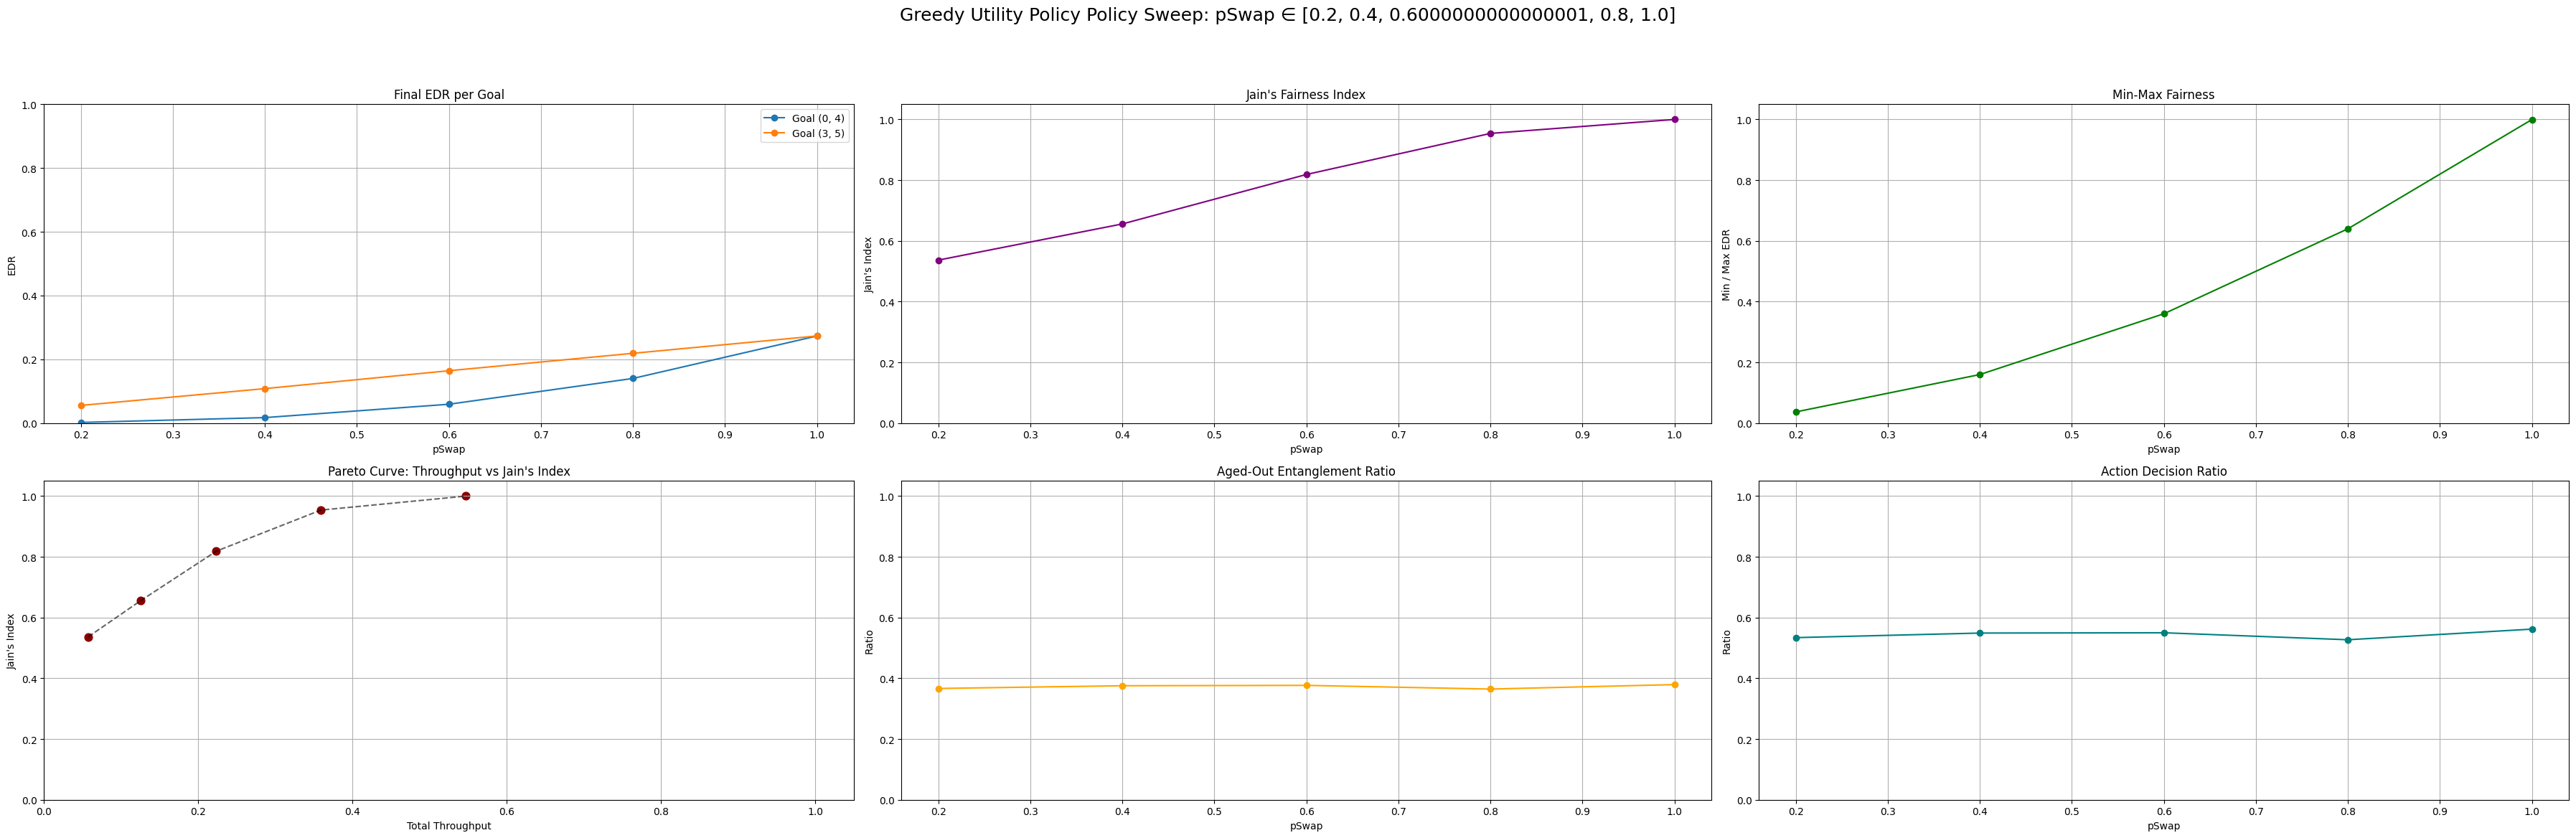

AttributeError: 'float' object has no attribute 'upper'

In [4]:
edges = [(0,1), (1,2), (2,3), (3,4), (2,5)]
goal_edges = [(0,4), (3,5)]

# Swap and generation probabilities
pSwap = 0.6
pGen = 0.6
maxAge = 3

num_steps = 100_000
policy = 'utility'   # Choose between 'utility', 'random', 'lowest_edr', etc.
seed = 30
random.seed(seed)
np.random.seed(seed)

# === Define param sweep ===
param_values = [0.2 * i for i in range(1, 6)]  # [0.2, 0.4, 0.6, 0.8, 1.0]

# === Sweep over pSwap (or pGen, depending) ===
sweep_results = run_greedy_param_sweep(
    edges=edges,
    goalEdges=goal_edges,
    param_name='pSwap',              # <<< sweep over pSwap here!
    param_values=param_values,
    fixed_params={'pGen': pGen, 'pSwap': pSwap, 'maxAge': maxAge},
    policy=policy,                   # 'utility', 'lowest_edr', etc.
    num_steps=num_steps,
    plot=False                       # We'll plot manually afterward
)

# === Full analysis plot ===
plot_full_greedy_param_analysis(
    results=sweep_results,
    param_vals=param_values,
    param_name='pSwap',               # Label the x-axis correctly
    goal_edges=goal_edges,
    policy_name="Greedy Utility Policy"  # Title the plots
)



=== Running Greedy for pSwap=0.1, pGen=0.1 ===
Running UTILITY with pSwap=0.1

=== Running Greedy for pSwap=0.2, pGen=0.1 ===
Running UTILITY with pSwap=0.2

=== Running Greedy for pSwap=0.3, pGen=0.1 ===
Running UTILITY with pSwap=0.3

=== Running Greedy for pSwap=0.4, pGen=0.1 ===
Running UTILITY with pSwap=0.4

=== Running Greedy for pSwap=0.5, pGen=0.1 ===
Running UTILITY with pSwap=0.5

=== Running Greedy for pSwap=0.6, pGen=0.1 ===
Running UTILITY with pSwap=0.6

=== Running Greedy for pSwap=0.7, pGen=0.1 ===
Running UTILITY with pSwap=0.7

=== Running Greedy for pSwap=0.8, pGen=0.1 ===
Running UTILITY with pSwap=0.8

=== Running Greedy for pSwap=0.9, pGen=0.1 ===
Running UTILITY with pSwap=0.9

=== Running Greedy for pSwap=1, pGen=0.1 ===
Running UTILITY with pSwap=1

=== Running Greedy for pSwap=0.1, pGen=0.2 ===
Running UTILITY with pSwap=0.1

=== Running Greedy for pSwap=0.2, pGen=0.2 ===
Running UTILITY with pSwap=0.2

=== Running Greedy for pSwap=0.3, pGen=0.2 ===
Running 

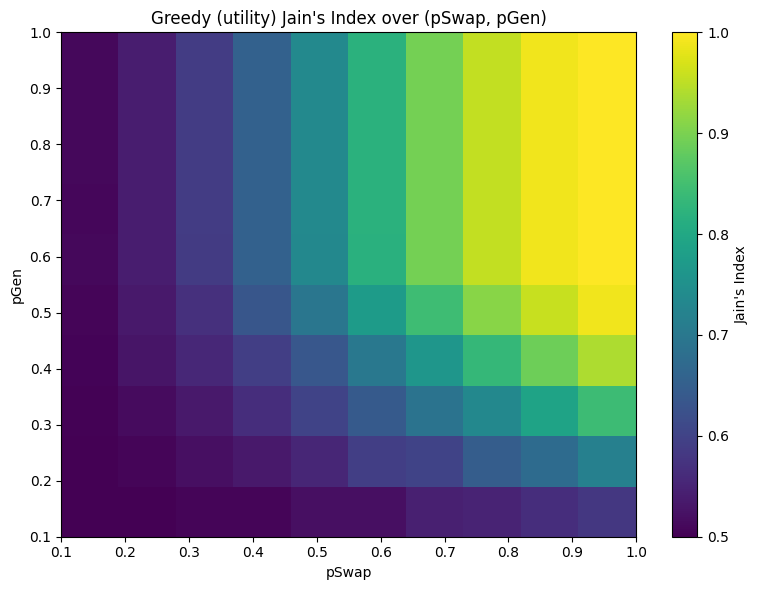

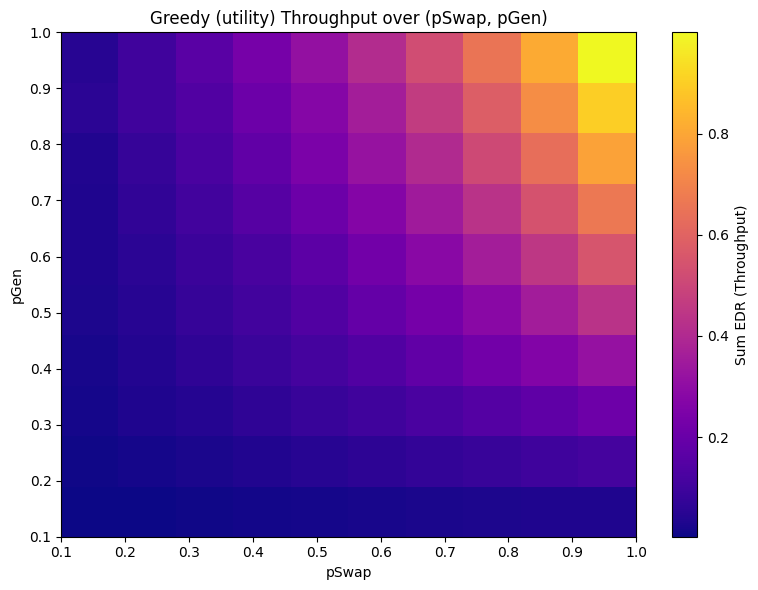

In [11]:
pSwap_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
pGen_values =[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

pSwap = 0.6
pGen = 0.6
maxAge = 3

num_steps = 50_000
policy = 'utility'   # 'utility', 'random', 'lowest_edr', etc.
seed = 30
random.seed(seed)
np.random.seed(seed)

# Prepare matrices
jain_matrix = np.zeros((len(pGen_values), len(pSwap_values)))
edr_matrix  = np.zeros((len(pGen_values), len(pSwap_values)))

# --- Loop over (pGen, pSwap) grid ---
for i, pGen_val in enumerate(pGen_values):
    for j, pSwap_val in enumerate(pSwap_values):
        print(f"\n=== Running Greedy for pSwap={pSwap_val}, pGen={pGen_val} ===")
        
        sweep_results = run_greedy_param_sweep(
            edges=edges,
            goalEdges=goal_edges,
            param_name='pSwap',  
            param_values=[pSwap_val],  
            fixed_params={'pGen': pGen_val, 'pSwap': pSwap_val, 'maxAge': maxAge},
            policy=policy,  
            num_steps=num_steps,
            plot=False  
        )

        result = sweep_results[pSwap_val]  # single param_value, direct access

        # --- CORRECT way to extract for Greedy ---
        jain = result['jain']            # directly
        edr_sum = result['throughput']    # directly

        jain_matrix[i, j] = jain
        edr_matrix[i, j] = edr_sum



# --- Now plot heatmaps ---

# (1) Jain's Index Heatmap
plt.figure(figsize=(8,6))
plt.imshow(jain_matrix, origin='lower', cmap='viridis',
           extent=[min(pSwap_values), max(pSwap_values), min(pGen_values), max(pGen_values)],
           aspect='auto')
plt.colorbar(label="Jain's Index")
plt.xlabel('pSwap')
plt.ylabel('pGen')
plt.title(f"Greedy ({policy}) Jain's Index over (pSwap, pGen)")
plt.xticks(pSwap_values)
plt.yticks(pGen_values)
plt.grid(False)
plt.tight_layout()
plt.show()

# (2) EDR Sum (Throughput) Heatmap
plt.figure(figsize=(8,6))
plt.imshow(edr_matrix, origin='lower', cmap='plasma',
           extent=[min(pSwap_values), max(pSwap_values), min(pGen_values), max(pGen_values)],
           aspect='auto')
plt.colorbar(label="Sum EDR (Throughput)")
plt.xlabel('pSwap')
plt.ylabel('pGen')
plt.title(f"Greedy ({policy}) Throughput over (pSwap, pGen)")
plt.xticks(pSwap_values)
plt.yticks(pGen_values)
plt.grid(False)
plt.tight_layout()
plt.show()



=== Running Greedy UTILITY with maxAge=1 ===

=== Running Greedy UTILITY with maxAge=2 ===

=== Running Greedy UTILITY with maxAge=3 ===

=== Running Greedy UTILITY with maxAge=4 ===

=== Running Greedy UTILITY with maxAge=5 ===

=== Running Greedy UTILITY with maxAge=6 ===


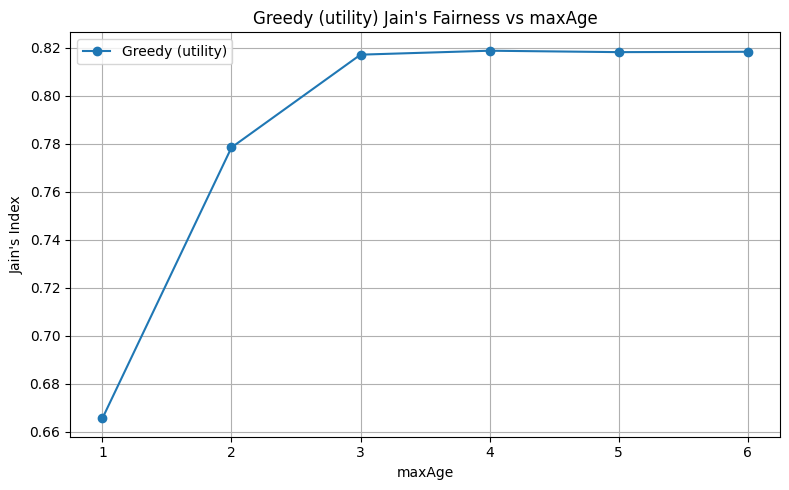

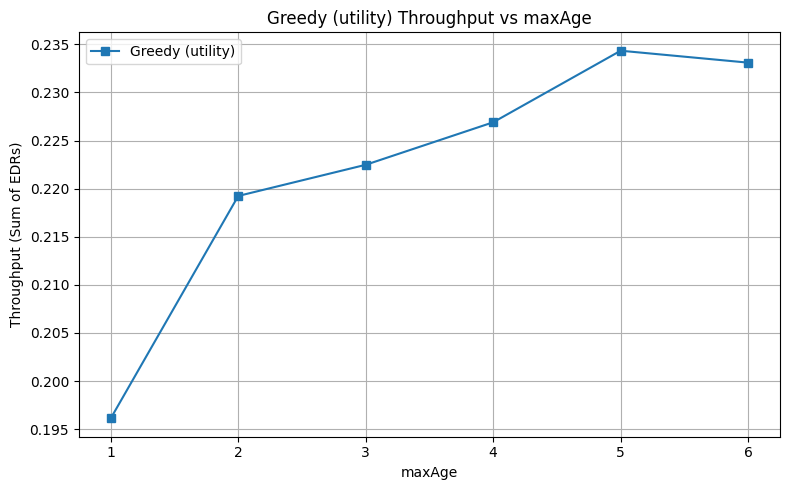

In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt

# === Setup common parameters ===
edges = [(0,1), (1,2), (2,3), (3,4), (2,5)]
goal_edges = [(0,4), (3,5)]

pSwap = 0.6
pGen = 0.6
policy_type = 'utility'   # <-- Choose: 'utility', 'lowest_edr', 'random', etc.
seed = 30
random.seed(seed)
np.random.seed(seed)

maxAge_values = [1, 2, 3, 4, 5, 6]
num_steps = 50_000

# === Prepare storage ===
greedy_jain_scores = []
greedy_throughput_scores = []

# === Sweep over maxAge ===
for maxAge_val in maxAge_values:
    print(f"\n=== Running Greedy {policy_type.upper()} with maxAge={maxAge_val} ===")

    edr_history, fairness_history, goals_achieved, goal_attempts, total_timesteps, aged, actions = simulate_policy_multi_greedy(
        edges, goal_edges, pSwap, pGen, maxAge_val, policy_type, num_steps
    )

    # Compute final metrics
    final_edrs = {g: goals_achieved[g] / max(1, total_timesteps) for g in goal_edges}
    final_throughput = sum(final_edrs.values())
    final_jain = jains_index(final_edrs)

    greedy_jain_scores.append(final_jain)
    greedy_throughput_scores.append(final_throughput)

# === Plot Results ===

# (1) Jain's Index vs maxAge
plt.figure(figsize=(8,5))
plt.plot(maxAge_values, greedy_jain_scores, marker='o', linestyle='-', label=f"Greedy ({policy_type})")
plt.xlabel("maxAge")
plt.ylabel("Jain's Index")
plt.title(f"Greedy ({policy_type}) Jain's Fairness vs maxAge")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# (2) Throughput vs maxAge
plt.figure(figsize=(8,5))
plt.plot(maxAge_values, greedy_throughput_scores, marker='s', linestyle='-', label=f"Greedy ({policy_type})")
plt.xlabel("maxAge")
plt.ylabel("Throughput (Sum of EDRs)")
plt.title(f"Greedy ({policy_type}) Throughput vs maxAge")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Return results for future comparison ===
greedy_results = {
    "maxAge_values": maxAge_values,
    "greedy_jain": greedy_jain_scores,
    "greedy_throughput": greedy_throughput_scores
}
